In [ ]:
!rm -rf data/crema cremad.zip

In [ ]:
!pip install -q kaggle torchaudio librosa transformers pandas scikit-learn matplotlib tqdm noisereduce audiomentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 7.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
project_path = '/content/drive/MyDrive/SER_Research_Project'
os.makedirs(project_path, exist_ok=True)
print(f"Project directory: {project_path}")

Project directory: /content/drive/MyDrive/SER_Research_Project


In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 94% 404M/429M [00:07<00:00, 66.0MB/s]
100% 429M/429M [00:07<00:00, 58.8MB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 96% 410M/428M [00:01<00:00, 253MB/s]
100% 428M/428M [00:01<00:00, 302MB/s]


In [ ]:
!mkdir -p data/ravdess data/tess

!unzip -q ravdess-emotional-speech-audio.zip -d data/ravdess
!unzip -q toronto-emotional-speech-set-tess.zip -d data/tess

In [ ]:
!ls data/ravdess | head
!ls data/tess | head

Actor_01
Actor_02
Actor_03
Actor_04
Actor_05
Actor_06
Actor_07
Actor_08
Actor_09
Actor_10
tess toronto emotional speech set data
TESS Toronto emotional speech set data


In [ ]:
!find data/ravdess -type f | wc -l
!find data/tess -type f | wc -l

2880
5600


In [ ]:
emotion_map = {
    'neutral': 0,
    'calm': 1,
    'happy': 2,
    'sad': 3,
    'angry': 4,
    'fearful': 5,
    'disgust': 6,
    'surprised': 7
}

def resolve_emotion(label):
    remap = {
        'fear': 'fearful',
        'ps': 'surprised',  # optional handling if you want to include these
        'pleasant_surprise': 'surprised'
    }
    return remap.get(label, label)

dataset_config = {
    'ravdess': {
        'path': 'data/ravdess',
        'mapping': lambda f: int(f.split('-')[2]) - 1  # already numeric
    },
    'tess': {
        'path': 'data/tess',
        'mapping': lambda f: emotion_map.get(
            resolve_emotion(f.split('_')[-1].split('.')[0].lower()), -1
        )
    }
}

In [ ]:
import audiomentations as aa
augment = aa.Compose([
    aa.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    aa.PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    aa.TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    aa.Gain(min_gain_db=-12, max_gain_db=12, p=0.3),
    aa.HighPassFilter(min_cutoff_freq=100, max_cutoff_freq=1000, p=0.4)
])

from noisereduce import reduce_noise
def extract_features(file_path, do_augment=False):
    # Load audio
    y, sr = librosa.load(file_path, sr=22050)

    # Apply noise reduction
    y = reduce_noise(y=y, sr=sr, stationary=True)

    # Apply augmentations
    if do_augment:
        y = augment(samples=y, sample_rate=sr)

    # Trim silence
    y, _ = librosa.effects.trim(y, top_db=25)

    # Pad/trim to 4 seconds
    target_length = 4 * sr
    if len(y) > target_length:
        y = y[:target_length]
    else:
        y = np.pad(y, (0, max(0, target_length - len(y))))

    # Extract features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=64, n_fft=2048, hop_length=512)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=2048, hop_length=512)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=2048, hop_length=512)

    # Combine features
    features = np.vstack([mfcc, chroma, mel, contrast])
    return features

In [ ]:
# Build dataset
def create_dataset():
    features = []
    labels = []

    for dataset, config in dataset_config.items():
        print(f"Processing {dataset} dataset...")
        path = config['path']
        mapping_func = config['mapping']

        for root, _, files in os.walk(path):
            for file in tqdm(files):
                if file.endswith('.wav'):
                    try:
                        file_path = os.path.join(root, file)
                        label = mapping_func(file)

                        # Extract base features
                        base_features = extract_features(file_path)

                        # Extract augmented features
                        augmented_features = extract_features(file_path, do_augment=True)

                        features.append(base_features)
                        labels.append(label)

                        features.append(augmented_features)
                        labels.append(label)

                    except Exception as e:
                        print(f"Skipping {file}: {str(e)}")

    return np.array(features), np.array(labels)


In [ ]:
dataset_path = f"{project_path}/ser_dataset.npz"
if not os.path.exists(dataset_path):
    X, y = create_dataset()
    np.savez(dataset_path, X=X, y=y)
    print(f"Dataset saved to Drive: {dataset_path}")
else:
    data = np.load(dataset_path)
    X, y = data['X'], data['y']
    print(f"Loaded dataset from Drive: {X.shape} samples")

Loaded dataset from Drive: (16960, 211, 173) samples


In [ ]:
project_path = '/content/drive/MyDrive/Speech_Emotion_Recognition'
import numpy as np

data = np.load(f"{project_path}/ser_dataset.npz")
X, y = data['X'], data['y']
print(X.shape, y.shape)

(6880, 94, 180) (6880,)


In [ ]:
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn as nn

class SERModel(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        # CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d((4, 4))
        )

        # Transformer Encoder
        encoder_layers = TransformerEncoderLayer(
    d_model=256, nhead=8, dim_feedforward=1024, dropout=0.2, batch_first=True
)
        self.transformer = TransformerEncoder(encoder_layers, num_layers=3)

        # Attention Mechanism
        self.attention = nn.Sequential(
    nn.Linear(256, 128),
    nn.Tanh(),
    nn.Linear(128, 1),
    nn.Softmax(dim=1)
)

# Classifier
        self.classifier = nn.Sequential(
    nn.Linear(256, 128),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.4),
    nn.Linear(128, num_classes)
)

    def forward(self, x):
      x = self.cnn(x)
      x = x.view(x.size(0), x.size(1), -1)  # [B, C, H*W]
      x = x.transpose(1, 2)  # [B, seq_len, features] — safe and readable
      x = self.transformer(x)
      attn_weights = self.attention(x)
      x = torch.sum(attn_weights * x, dim=1)
      return self.classifier(x)


In [ ]:
# Initialize model
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SERModel().to(device)
print(f"Model initialized on {device} | Parameters: {sum(p.numel() for p in model.parameters()):,}")


Model initialized on cpu | Parameters: 2,806,793


In [ ]:
from torch.utils.data import Dataset
import torch

class SERDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float().unsqueeze(1)  # [N, 1, H, W]
        self.y = torch.from_numpy(y).long()                # [N]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Wrap in PyTorch Datasets
train_dataset = SERDataset(X_train, y_train)
val_dataset = SERDataset(X_val, y_val)
test_dataset = SERDataset(X_test, y_test)

# DataLoaders (with pinned memory for performance if using GPU)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, pin_memory=True)

# Print split info
print(" Dataset Split:")
print(f"- Training samples:   {len(train_dataset)}")
print(f"- Validation samples: {len(val_dataset)}")
print(f"- Test samples:       {len(test_dataset)}")

 Dataset Split:
- Training samples:   4816
- Validation samples: 1032
- Test samples:       1032


In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

early_stopping_patience = 7
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []
val_accuracies = []

Epoch 1: 100%|██████████| 151/151 [13:11<00:00,  5.24s/it, loss=4.19]


Epoch 1 | Train Loss: 5.3887 | Val Accuracy: 16.67%
💾 Saved new best model (Val Acc: 16.67%)


Epoch 2: 100%|██████████| 151/151 [13:04<00:00,  5.19s/it, loss=3.09]


Epoch 2 | Train Loss: 3.9102 | Val Accuracy: 46.03%
💾 Saved new best model (Val Acc: 46.03%)


Epoch 3: 100%|██████████| 151/151 [13:12<00:00,  5.25s/it, loss=2.84]


Epoch 3 | Train Loss: 3.2674 | Val Accuracy: 54.36%
💾 Saved new best model (Val Acc: 54.36%)


Epoch 4: 100%|██████████| 151/151 [13:07<00:00,  5.22s/it, loss=2.75]


Epoch 4 | Train Loss: 2.8660 | Val Accuracy: 43.99%


Epoch 5: 100%|██████████| 151/151 [13:21<00:00,  5.31s/it, loss=2.2]


Epoch 5 | Train Loss: 2.6065 | Val Accuracy: 64.92%
💾 Saved new best model (Val Acc: 64.92%)


Epoch 6: 100%|██████████| 151/151 [13:09<00:00,  5.23s/it, loss=2.09]


Epoch 6 | Train Loss: 2.3722 | Val Accuracy: 76.45%
💾 Saved new best model (Val Acc: 76.45%)


Epoch 7: 100%|██████████| 151/151 [13:01<00:00,  5.18s/it, loss=2.2]


Epoch 7 | Train Loss: 2.2557 | Val Accuracy: 76.07%


Epoch 8: 100%|██████████| 151/151 [13:09<00:00,  5.23s/it, loss=2.26]


Epoch 8 | Train Loss: 2.1653 | Val Accuracy: 77.52%
💾 Saved new best model (Val Acc: 77.52%)


Epoch 9: 100%|██████████| 151/151 [13:01<00:00,  5.18s/it, loss=2.05]


Epoch 9 | Train Loss: 2.0757 | Val Accuracy: 77.62%
💾 Saved new best model (Val Acc: 77.62%)


Epoch 10: 100%|██████████| 151/151 [12:58<00:00,  5.15s/it, loss=1.98]


Epoch 10 | Train Loss: 1.9874 | Val Accuracy: 79.46%
💾 Saved new best model (Val Acc: 79.46%)


Epoch 11: 100%|██████████| 151/151 [13:00<00:00,  5.17s/it, loss=1.85]


Epoch 11 | Train Loss: 1.9448 | Val Accuracy: 78.97%


Epoch 12: 100%|██████████| 151/151 [12:58<00:00,  5.16s/it, loss=1.6]


Epoch 12 | Train Loss: 1.8958 | Val Accuracy: 78.88%


Epoch 13: 100%|██████████| 151/151 [13:03<00:00,  5.19s/it, loss=1.89]


Epoch 13 | Train Loss: 1.8694 | Val Accuracy: 80.72%
💾 Saved new best model (Val Acc: 80.72%)


Epoch 14: 100%|██████████| 151/151 [13:05<00:00,  5.20s/it, loss=1.89]


Epoch 14 | Train Loss: 1.8167 | Val Accuracy: 81.59%
💾 Saved new best model (Val Acc: 81.59%)


Epoch 15: 100%|██████████| 151/151 [13:07<00:00,  5.22s/it, loss=1.75]


Epoch 15 | Train Loss: 1.7889 | Val Accuracy: 82.75%
💾 Saved new best model (Val Acc: 82.75%)


Epoch 16: 100%|██████████| 151/151 [13:04<00:00,  5.20s/it, loss=1.94]


Epoch 16 | Train Loss: 1.7647 | Val Accuracy: 81.10%


Epoch 17: 100%|██████████| 151/151 [13:05<00:00,  5.21s/it, loss=1.73]


Epoch 17 | Train Loss: 1.7566 | Val Accuracy: 82.85%
💾 Saved new best model (Val Acc: 82.85%)


Epoch 18: 100%|██████████| 151/151 [13:09<00:00,  5.23s/it, loss=1.68]


Epoch 18 | Train Loss: 1.7202 | Val Accuracy: 83.04%
💾 Saved new best model (Val Acc: 83.04%)


Epoch 19: 100%|██████████| 151/151 [13:04<00:00,  5.20s/it, loss=1.86]


Epoch 19 | Train Loss: 1.7102 | Val Accuracy: 82.85%


Epoch 20: 100%|██████████| 151/151 [13:22<00:00,  5.31s/it, loss=1.72]


Epoch 20 | Train Loss: 1.6965 | Val Accuracy: 84.01%
💾 Saved new best model (Val Acc: 84.01%)


Epoch 21: 100%|██████████| 151/151 [13:06<00:00,  5.21s/it, loss=1.64]


Epoch 21 | Train Loss: 1.6809 | Val Accuracy: 83.43%


Epoch 22: 100%|██████████| 151/151 [13:01<00:00,  5.18s/it, loss=1.48]


Epoch 22 | Train Loss: 1.6735 | Val Accuracy: 84.30%
💾 Saved new best model (Val Acc: 84.30%)


Epoch 23: 100%|██████████| 151/151 [13:04<00:00,  5.19s/it, loss=1.66]


Epoch 23 | Train Loss: 1.6569 | Val Accuracy: 84.40%
💾 Saved new best model (Val Acc: 84.40%)


Epoch 24: 100%|██████████| 151/151 [13:01<00:00,  5.18s/it, loss=1.91]


Epoch 24 | Train Loss: 1.6608 | Val Accuracy: 84.50%
💾 Saved new best model (Val Acc: 84.50%)


Epoch 25: 100%|██████████| 151/151 [12:58<00:00,  5.15s/it, loss=1.4]


Epoch 25 | Train Loss: 1.6577 | Val Accuracy: 84.30%


Epoch 26: 100%|██████████| 151/151 [13:05<00:00,  5.20s/it, loss=1.48]


Epoch 26 | Train Loss: 1.6426 | Val Accuracy: 84.30%


Epoch 27: 100%|██████████| 151/151 [12:58<00:00,  5.15s/it, loss=1.63]


Epoch 27 | Train Loss: 1.6424 | Val Accuracy: 84.50%


Epoch 28: 100%|██████████| 151/151 [13:02<00:00,  5.19s/it, loss=1.65]


Epoch 28 | Train Loss: 1.6408 | Val Accuracy: 84.11%


Epoch 29: 100%|██████████| 151/151 [13:11<00:00,  5.24s/it, loss=1.34]


Epoch 29 | Train Loss: 1.6445 | Val Accuracy: 83.82%


Epoch 30: 100%|██████████| 151/151 [13:09<00:00,  5.23s/it, loss=1.66]


Epoch 30 | Train Loss: 1.6334 | Val Accuracy: 84.30%


Epoch 31: 100%|██████████| 151/151 [13:13<00:00,  5.25s/it, loss=1.54]


Epoch 31 | Train Loss: 1.6292 | Val Accuracy: 84.11%


Epoch 32: 100%|██████████| 151/151 [13:15<00:00,  5.27s/it, loss=1.75]


Epoch 32 | Train Loss: 1.6239 | Val Accuracy: 84.30%


Epoch 33: 100%|██████████| 151/151 [13:19<00:00,  5.30s/it, loss=1.69]


Epoch 33 | Train Loss: 1.6269 | Val Accuracy: 84.30%


Epoch 34: 100%|██████████| 151/151 [13:12<00:00,  5.25s/it, loss=1.44]


Epoch 34 | Train Loss: 1.6241 | Val Accuracy: 84.11%
⛔ Early stopping triggered at epoch 34


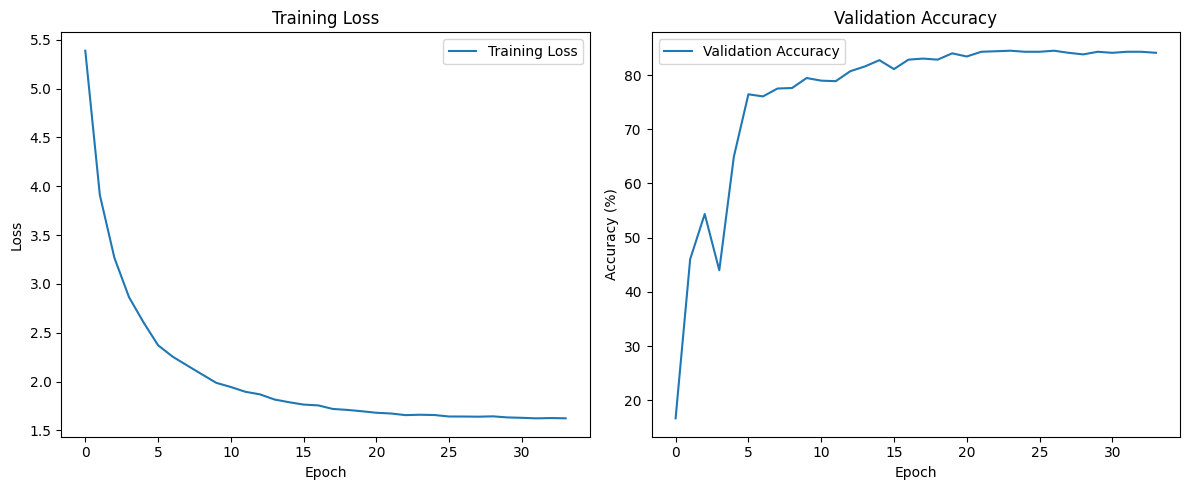

 Training history saved to /content/drive/MyDrive/Speech_Emotion_Recognition/training_history.png

 Final Test Accuracy: 82.46%
              precision    recall  f1-score   support

     neutral       0.97      0.87      0.91       149
        calm       0.65      0.75      0.70        57
       happy       0.89      0.80      0.84       177
         sad       0.81      0.81      0.81       178
       angry       0.91      0.94      0.93       178
     fearful       0.42      0.52      0.47        58
     disgust       0.85      0.86      0.86       177
   surprised       0.69      0.74      0.72        58

    accuracy                           0.82      1032
   macro avg       0.78      0.79      0.78      1032
weighted avg       0.83      0.82      0.83      1032



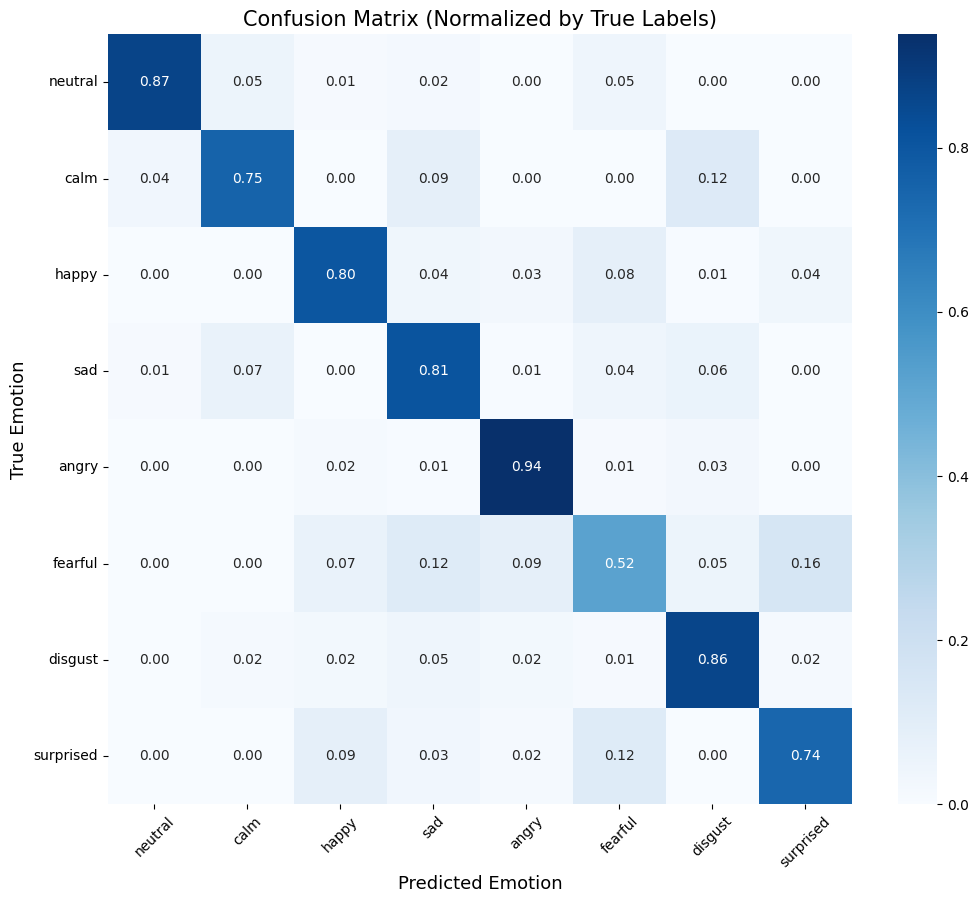

Confusion matrix saved to /content/drive/MyDrive/Speech_Emotion_Recognition/confusion_matrix.png
 Full model saved to /content/drive/MyDrive/Speech_Emotion_Recognition/full_ser_model.pth


In [ ]:
best_val_accuracy = 0
epochs_no_improve = 0
early_stopping_patience = 10  # Or any value you prefer
train_losses = []
val_accuracies = []

for epoch in range(100):  # Max 100 epochs
    # Training phase
    model.train()
    total_loss = 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for batch_x, batch_y in progress:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Add L2 regularization
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    # Update scheduler
    scheduler.step(val_accuracy)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")

    # Early stopping check
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), f"{project_path}/ser_model_best.pth")
        print(f"💾 Saved new best model (Val Acc: {val_accuracy:.2f}%)")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print(f"⛔ Early stopping triggered at epoch {epoch+1}")
            break

import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
history_path = f"{project_path}/training_history.png"
plt.savefig(history_path)
plt.show()
print(f" Training history saved to {history_path}")

# Load best model
model.load_state_dict(torch.load(f"{project_path}/ser_model_best.pth"))
model.eval()

# Test evaluation
all_preds = []
all_true = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(batch_y.cpu().numpy())

final_accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_true))
print(f"\n Final Test Accuracy: {final_accuracy:.2f}%")
print(classification_report(all_true, all_preds, target_names=list(emotion_map.keys())))

# Confusion matrix
cm = confusion_matrix(all_true, all_preds, normalize='true')
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=list(emotion_map.keys()),
            yticklabels=list(emotion_map.keys()))
plt.title('Confusion Matrix (Normalized by True Labels)', fontsize=15)
plt.xlabel('Predicted Emotion', fontsize=13)
plt.ylabel('True Emotion', fontsize=13)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

confusion_path = f"{project_path}/confusion_matrix.png"
plt.savefig(confusion_path, bbox_inches='tight')
plt.show()
print(f"Confusion matrix saved to {confusion_path}")

# Save full model
torch.save(model, f"{project_path}/full_ser_model.pth")
print(f" Full model saved to {project_path}/full_ser_model.pth")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from google.colab import drive

# Mount Google Drive to access your files
drive.mount('/content/drive')

# The model architecture must be defined to load the weights
class SERModel(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        # CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d((4, 4))
        )

        # Transformer Encoder
        encoder_layers = TransformerEncoderLayer(
            d_model=256, nhead=8, dim_feedforward=1024, dropout=0.2, batch_first=True
        )
        self.transformer = TransformerEncoder(encoder_layers, num_layers=3)

        # Attention Mechanism
        self.attention = nn.Sequential(
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), x.size(1), -1)  # [B, C, H*W]
        x = x.transpose(1, 2)  # [B, seq_len, features]
        x = self.transformer(x)
        attn_weights = self.attention(x)
        x = torch.sum(attn_weights * x, dim=1)
        return self.classifier(x)

# Define the number of classes to match your trained model
# Your trained model has 8 classes, not 7, based on the error.
num_classes = 8

# The path to your project folder, based on your previous output.
project_path = "/content/drive/MyDrive/Speech_Emotion_Recognition"

# Initialize a new model instance
model = SERModel(num_classes)

# Load the best weights from your previous training run
best_model_path = f"{project_path}/ser_model_best.pth"
model.load_state_dict(torch.load(best_model_path, map_location=torch.device('cpu')))

# Now, save the state_dict to the final file, correcting the issue.
save_path = f"{project_path}/full_ser_model.pth"
torch.save(model.state_dict(), save_path)

print(f"✅ Successfully created a new model file at {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Successfully created a new model file at /content/drive/MyDrive/Speech_Emotion_Recognition/full_ser_model.pth


In [5]:
from pyngrok import ngrok
ngrok.set_auth_token("311lzzMw2oGxwKxPlkRPGH0ygmI_2hYK75a6yo2ytLWnuM5Bz")

In [ ]:
# =============================================================================
# Google Colab Flask API for Speech Emotion Recognition Model
# Copy this entire code block into a NEW CELL in your Colab notebook
# Run it AFTER your model training is complete
# =============================================================================
from google.colab import drive
drive.mount('/content/drive')

!pip install flask flask-cors pyngrok noisereduce
import os
import io
import base64
import numpy as np
import librosa
import torch
import torch.nn as nn
from flask import Flask, request, jsonify
from flask_cors import CORS
from pyngrok import ngrok
import warnings
warnings.filterwarnings('ignore')

# Import your model class (same as in your training)
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class SERModel(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        # CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d((4, 4))
        )

        # Transformer Encoder
        encoder_layers = TransformerEncoderLayer(
            d_model=256, nhead=8, dim_feedforward=1024, dropout=0.2, batch_first=True
        )
        self.transformer = TransformerEncoder(encoder_layers, num_layers=3)

        # Attention Mechanism
        self.attention = nn.Sequential(
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), x.size(1), -1)  # [B, C, H*W]
        x = x.transpose(1, 2)  # [B, seq_len, features]
        x = self.transformer(x)
        attn_weights = self.attention(x)
        x = torch.sum(attn_weights * x, dim=1)
        return self.classifier(x)

# Initialize and load your trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SERModel(num_classes=8).to(device)

# Load your trained model weights
project_path = '/content/drive/MyDrive/Speech_Emotion_Recognition'
model.load_state_dict(torch.load(f"{project_path}/ser_model_best.pth", map_location=device))
model.eval()
print("✅ Model loaded successfully!")

# Emotion mapping (same as your training)
emotion_map = {
    'neutral': 0,
    'calm': 1,
    'happy': 2,
    'sad': 3,
    'angry': 4,
    'fearful': 5,
    'disgust': 6,
    'surprised': 7
}

# Reverse mapping for predictions
id_to_emotion = {v: k for k, v in emotion_map.items()}

# Feature extraction function (same as your training)
from noisereduce import reduce_noise

def extract_features(audio_data, sr=22050):
    """Extract features from audio data (numpy array)"""
    try:
        # Apply noise reduction
        y = reduce_noise(y=audio_data, sr=sr, stationary=True)

        # Trim silence
        y, _ = librosa.effects.trim(y, top_db=25)

        # Pad/trim to 4 seconds
        target_length = 4 * sr
        if len(y) > target_length:
            y = y[:target_length]
        else:
            y = np.pad(y, (0, max(0, target_length - len(y))))

        # Extract features (same as training)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=64, n_fft=2048, hop_length=512)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=2048, hop_length=512)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=2048, hop_length=512)

        # Combine features
        features = np.vstack([mfcc, chroma, mel, contrast])
        return features

    except Exception as e:
        print(f"Error in feature extraction: {str(e)}")
        return None

def predict_emotion(audio_data, sr=22050):
    """Predict emotion from audio data"""
    try:
        # Extract features
        features = extract_features(audio_data, sr)
        if features is None:
            return None

        # Convert to tensor and add batch dimension
        features_tensor = torch.from_numpy(features).float().unsqueeze(0).unsqueeze(0).to(device)

        # Make prediction
        with torch.no_grad():
            outputs = model(features_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            probabilities = probabilities.cpu().numpy()[0]

        # Convert to emotion probabilities dictionary
        emotion_probs = {}
        for emotion, emotion_id in emotion_map.items():
            emotion_probs[emotion] = float(probabilities[emotion_id])

        return emotion_probs

    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        return None

# Create Flask app
app = Flask(__name__)
CORS(app)  # Enable CORS for frontend integration

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Check if audio file is provided
        if 'audio' not in request.files:
            return jsonify({'error': 'No audio file provided'}), 400

        audio_file = request.files['audio']
        if audio_file.filename == '':
            return jsonify({'error': 'No audio file selected'}), 400

        # Load audio from uploaded file
        audio_data, sr = librosa.load(io.BytesIO(audio_file.read()), sr=22050)

        # Make prediction
        emotion_probs = predict_emotion(audio_data, sr)

        if emotion_probs is None:
            return jsonify({'error': 'Failed to process audio'}), 500

        # Find top emotion
        top_emotion = max(emotion_probs.items(), key=lambda x: x[1])

        response = {
            'success': True,
            'predictions': emotion_probs,
            'top_emotion': {
                'emotion': top_emotion[0],
                'confidence': top_emotion[1]
            }
        }

        return jsonify(response)

    except Exception as e:
        return jsonify({'error': f'Server error: {str(e)}'}), 500

@app.route('/health', methods=['GET'])
def health():
    return jsonify({'status': 'healthy', 'model': 'loaded'})

@app.route('/test', methods=['GET'])
def test():
    return jsonify({
        'message': 'SER API is running!',
        'emotions': list(emotion_map.keys()),
        'device': str(device)
    })

# Main execution
if __name__ == '__main__':
    print("🚀 Starting Speech Emotion Recognition API...")
    print("📊 Available emotions:", list(emotion_map.keys()))
    print(f"🖥️  Running on device: {device}")

    # Start ngrok tunnel to make API publicly accessible
    public_url = ngrok.connect(5000)
    print(f"\n🌐 Public URL: {public_url}")
    print(f"🔗 API Endpoints:")
    print(f"   - Health check: {public_url}/health")
    print(f"   - Test: {public_url}/test")
    print(f"   - Predict emotion: {public_url}/predict (POST)")
    print("\n💡 Copy the public URL above and use it in your HTML demo!")
    print("📋 Replace 'YOUR_NGROK_URL_HERE' in the HTML with this URL")

    # Run Flask app
    app.run(host='0.0.0.0', port=5000, debug=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model loaded successfully!
🚀 Starting Speech Emotion Recognition API...
📊 Available emotions: ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
🖥️  Running on device: cpu

🌐 Public URL: NgrokTunnel: "https://9815b3217e1f.ngrok-free.app" -> "http://localhost:5000"
🔗 API Endpoints:
   - Health check: NgrokTunnel: "https://9815b3217e1f.ngrok-free.app" -> "http://localhost:5000"/health
   - Test: NgrokTunnel: "https://9815b3217e1f.ngrok-free.app" -> "http://localhost:5000"/test
   - Predict emotion: NgrokTunnel: "https://9815b3217e1f.ngrok-free.app" -> "http://localhost:5000"/predict (POST)

💡 Copy the public URL above and use it in your HTML demo!
📋 Replace 'YOUR_NGROK_URL_HERE' in the HTML with this URL
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [09/Aug/2025 00:50:48] "OPTIONS /health HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Aug/2025 00:50:48] "GET /health HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Aug/2025 00:51:05] "OPTIONS /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Aug/2025 00:51:25] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Aug/2025 00:53:24] "OPTIONS /health HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Aug/2025 00:53:25] "GET /health HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Aug/2025 00:54:39] "OPTIONS /health HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Aug/2025 00:54:40] "GET /health HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Aug/2025 00:54:54] "OPTIONS /